# Evaluation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
from tqdm.auto import tqdm
import matplotlib.patches as patches
import cv2
pd.options.mode.chained_assignment = None  # default='warn'

Function for IoU calculation

In [2]:
def iou(box_gt, box_dt):
    # Assign variable names to coordinates for clarity
    (box_gt_x, box_gt_y, box_gt_w, box_gt_h) = box_gt
    (box_dt_x, box_dt_y, box_dt_w, box_dt_h) = box_dt
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box_gt_x, box_dt_x)
    yi1 = max(box_gt_y, box_dt_y)
    xi2 = min(box_gt_x + box_gt_w, box_dt_x + box_dt_w)
    yi2 = min(box_gt_y + box_gt_h, box_dt_y + box_dt_h)
    inter_width  = xi2 - xi1
    inter_height = yi2 - yi1
    inter_area   = inter_width * inter_height if inter_width > 0 and inter_height > 0 else 0
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box_gt_area  = box_gt_w * box_gt_h
    box_dt_area  = box_dt_w * box_dt_h
    union_area = box_gt_area + box_dt_area - inter_area
    # compute the IoU
    iou = inter_area / union_area 
    return iou

Open and read data from the CSV

In [3]:
df = pd.read_csv('input/train.csv')
repl=[]
for i in range(len(df)):
    row = df.iloc[i,3]
    row = row.replace(',', '')
    row = row.replace('[', '')
    row = row.replace(']', '')
    row= row.split()
    row = [round(float(i)) for i in row]
    repl.append(row)
arr = np.array(repl)
df['box_x'] = arr[:,0]
df['box_y'] = arr[:,1]
df['box_w'] = arr[:,2]
df['box_h'] = arr[:,3]

Check only files from the validation set

In [4]:
detect_dir = 'output/images'
file_names = os.listdir(detect_dir)
file_names = [items[:-4] for items in file_names]
df_val = df[df['image_id'].isin(file_names)]
df_val

,image_id,width,height,bbox,source,box_x,box_y,box_w,box_h
93,7b72ea0fb,1024,1024,"[332.0, 662.0, 113.0, 50.0]",usask_1,332,662,113,50
94,7b72ea0fb,1024,1024,"[285.0, 755.0, 31.0, 34.0]",usask_1,285,755,31,34
95,7b72ea0fb,1024,1024,"[126.0, 464.0, 65.0, 53.0]",usask_1,126,464,65,53
96,7b72ea0fb,1024,1024,"[363.0, 262.0, 68.0, 145.0]",usask_1,363,262,68,145
97,7b72ea0fb,1024,1024,"[912.0, 656.0, 97.0, 76.0]",usask_1,912,656,97,76
...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,64,619,84,95
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,292,549,107,82
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,134,228,141,71
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,430,13,184,79


count IoU for each bounding box in the DataFrame for thresholds **[.50, .65, .75]**. Each treshold will have its own place in the DataFrame for easy further calculations

In [5]:
sz= 1000
sh = -35
for fold in [.50, .65, .75]:
 
    print('Thrashold:', fold)
    lb_dir = './output/threshold{}/labels/'.format(int(fold*100))
    file_names = os.listdir(lb_dir)[:sz]
    for n, fl_name in tqdm(enumerate(file_names), total=len(file_names)):
    
        box_file = open(lb_dir + fl_name, "r")
        box_dt = []
        for tx_row in box_file:
            values = np.array(tx_row.split()).astype(np.float)
            box_dt_row= list([int(values[1]*1024)+sh, int(values[2]*1024)+sh, int(values[3]*1024), int(values[4]*1024)])
            box_dt.append(box_dt_row)
        box_file.close()
        for ind, box in df_val[df_val['image_id']==fl_name[:-4]].iterrows():
            box_gt = list([box.box_x, box.box_y, box.box_w, box.box_h])
            for tx_row in box_dt:
                ious = [iou(box_gt, tx_row) for tx_row in box_dt]
                df_val.loc[ind, 'iou{}'.format(int(fold*100))] = max(ious)
    print('mean IoU=', round(np.mean(df_val['iou{}'.format(int(fold*100))]),3))
   

Thrashold: 0.5



mean IoU= 0.528
Thrashold: 0.65



mean IoU= 0.477
Thrashold: 0.75



mean IoU= 0.324


Mean IoUs for each threshold and total mean

In [6]:
IoU50 = np.mean(df_val[df_val['iou50'].notnull()]['iou50'])
IoU65 = np.mean(df_val[df_val['iou65'].notnull()]['iou65'])
IoU75 = np.mean(df_val[df_val['iou75'].notnull()]['iou75'])
print(round(IoU50, 3), round(IoU65, 3), round(IoU75, 3)) 
print('Mean IoU:', round(np.mean([IoU50, IoU65, IoU75]),3))
#df_val.to_csv('out.csv', index=False)

0.528 0.477 0.324
Mean IoU: 0.443


In [7]:
list(df_val.nlargest(5, ['iou50'])['image_id']) 
demo_imgs = list(df_val.nlargest(5, ['iou50'])['image_id'])
demo_imgs = [name + '.jpg' for name in demo_imgs]
n_samples = len(demo_imgs)

Plot some samples with the highest IoU (total for image)

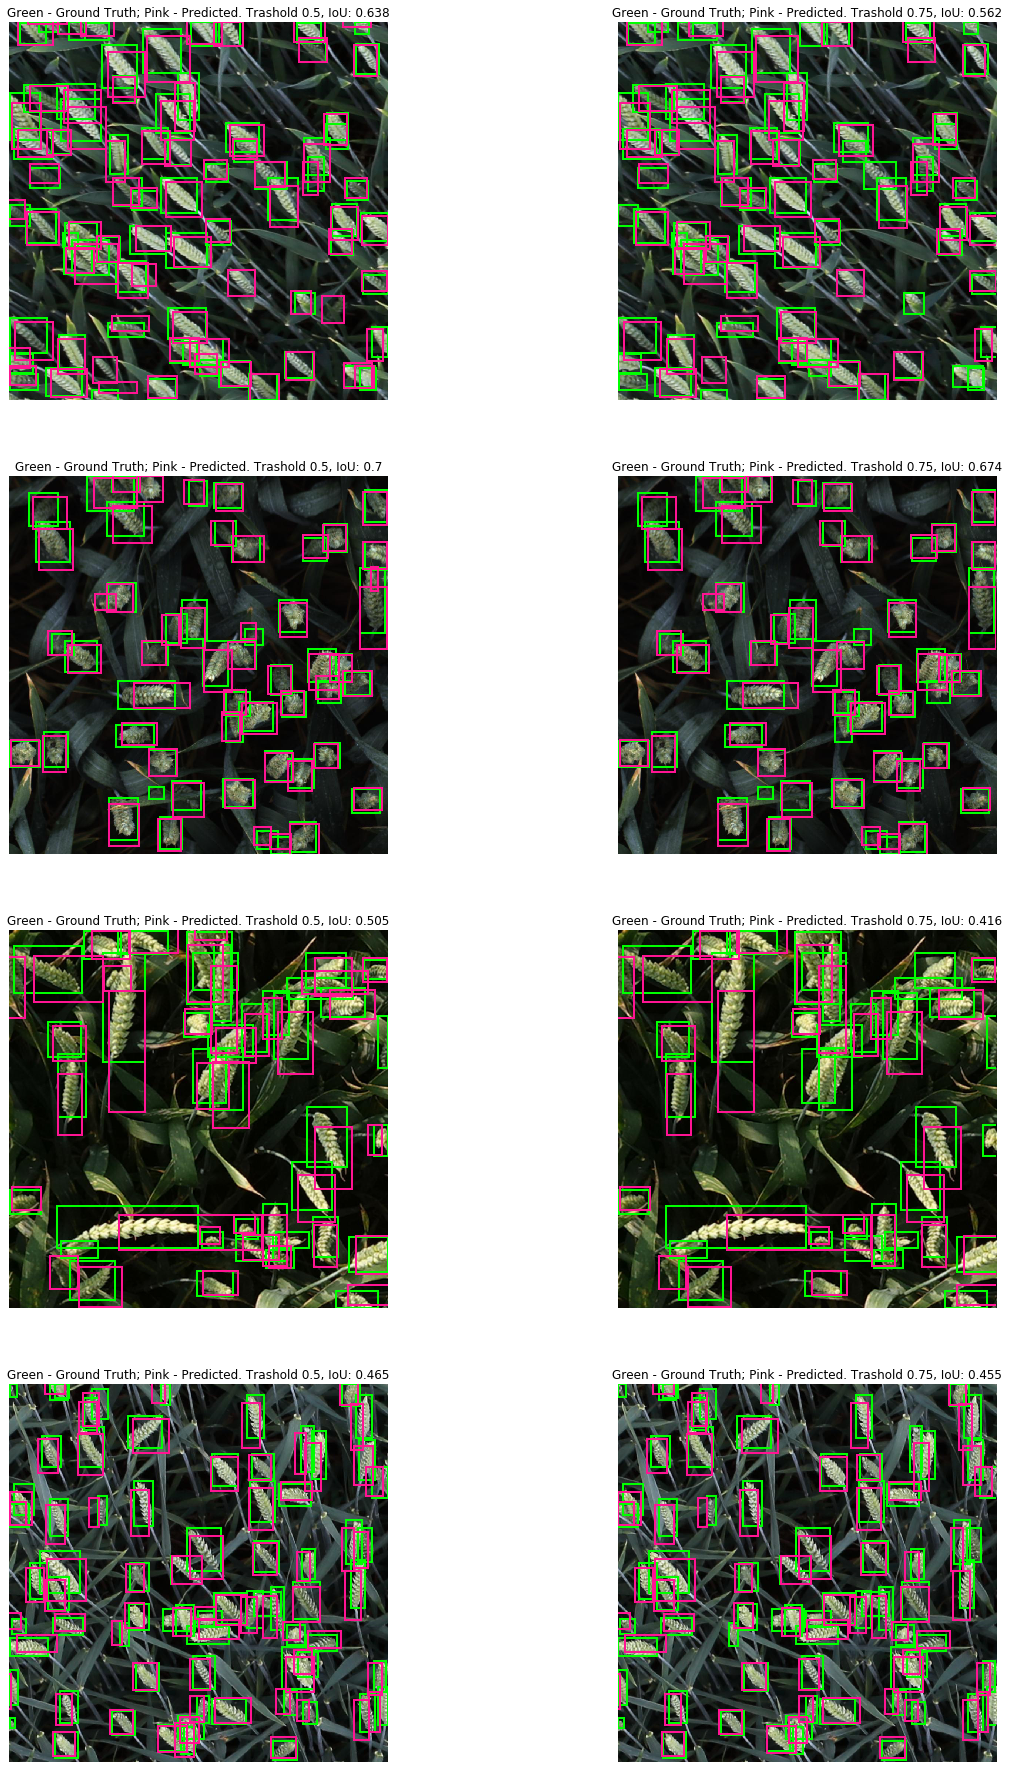

In [8]:
%matplotlib inline
detect_dir = 'output/images'
#detect_dir_50 = 'output/threshold50/images'
lb_dir_50 = 'output/threshold50/labels'
lb_dir_75 = 'output/threshold75/labels'
file_names = os.listdir(detect_dir)
sh=-35
demo_imgs = list(df_val.nlargest(4, ['iou50'])['image_id'])
demo_imgs = [name + '.jpg' for name in demo_imgs]
n_samples = len(demo_imgs)

fig, ax = plt.subplots(n_samples, 2, figsize=(20, 8 * n_samples))
for n, fl_name in enumerate(demo_imgs):
    for col in range(2):
        file_path = os.path.join(detect_dir, fl_name)
        img = plt.imread(file_path)
        ax[n,col].imshow(img)
        ax[n,col].axis('off')
        
        # read ground truth bounded boxes from CSV
        img_name = fl_name[:-4]
        for i, box in df_val[df_val['image_id']==img_name].iterrows():
            rect = patches.Rectangle((box.box_x,box.box_y),box.box_w,box.box_h,
                                linewidth=2,edgecolor='lime',facecolor='none')
            ax[n,col].add_patch(rect)
        # read predicted bounded boxes from *.txt files (treshold 0.5/0.75)
        if col==0:
            iou_im = df_val[df_val['image_id']==img_name]['iou50'].mean()
            ax[n,col].set_title('Green - Ground Truth; Pink - Predicted. Trashold 0.5, IoU: {}'.format(round(iou_im, 3)))
        else:
            iou_im = df_val[df_val['image_id']==img_name]['iou75'].mean()
            ax[n,col].set_title('Green - Ground Truth; Pink - Predicted. Trashold 0.75, IoU: {}'.format(round(iou_im, 3)))       
        txt_fl_name = fl_name[:-4]+'.txt'
        if col==0:
            file_path = os.path.join(lb_dir_50, txt_fl_name)
        else:
            file_path = os.path.join(lb_dir_75, txt_fl_name)
        box_file = open(file_path, "r")
        for aline in box_file:
            values = np.array(aline.split()).astype(np.float)
            rect = patches.Rectangle((int(values[1]*1024+sh), int(values[2]*1024 + sh)),
                                    values[3]*1024, values[4]*1024,
                                linewidth=2,edgecolor='deeppink',facecolor='none')
            ax[n,col].add_patch(rect)
        box_file.close()

Plot some samples with the lowest IoU (total for image)

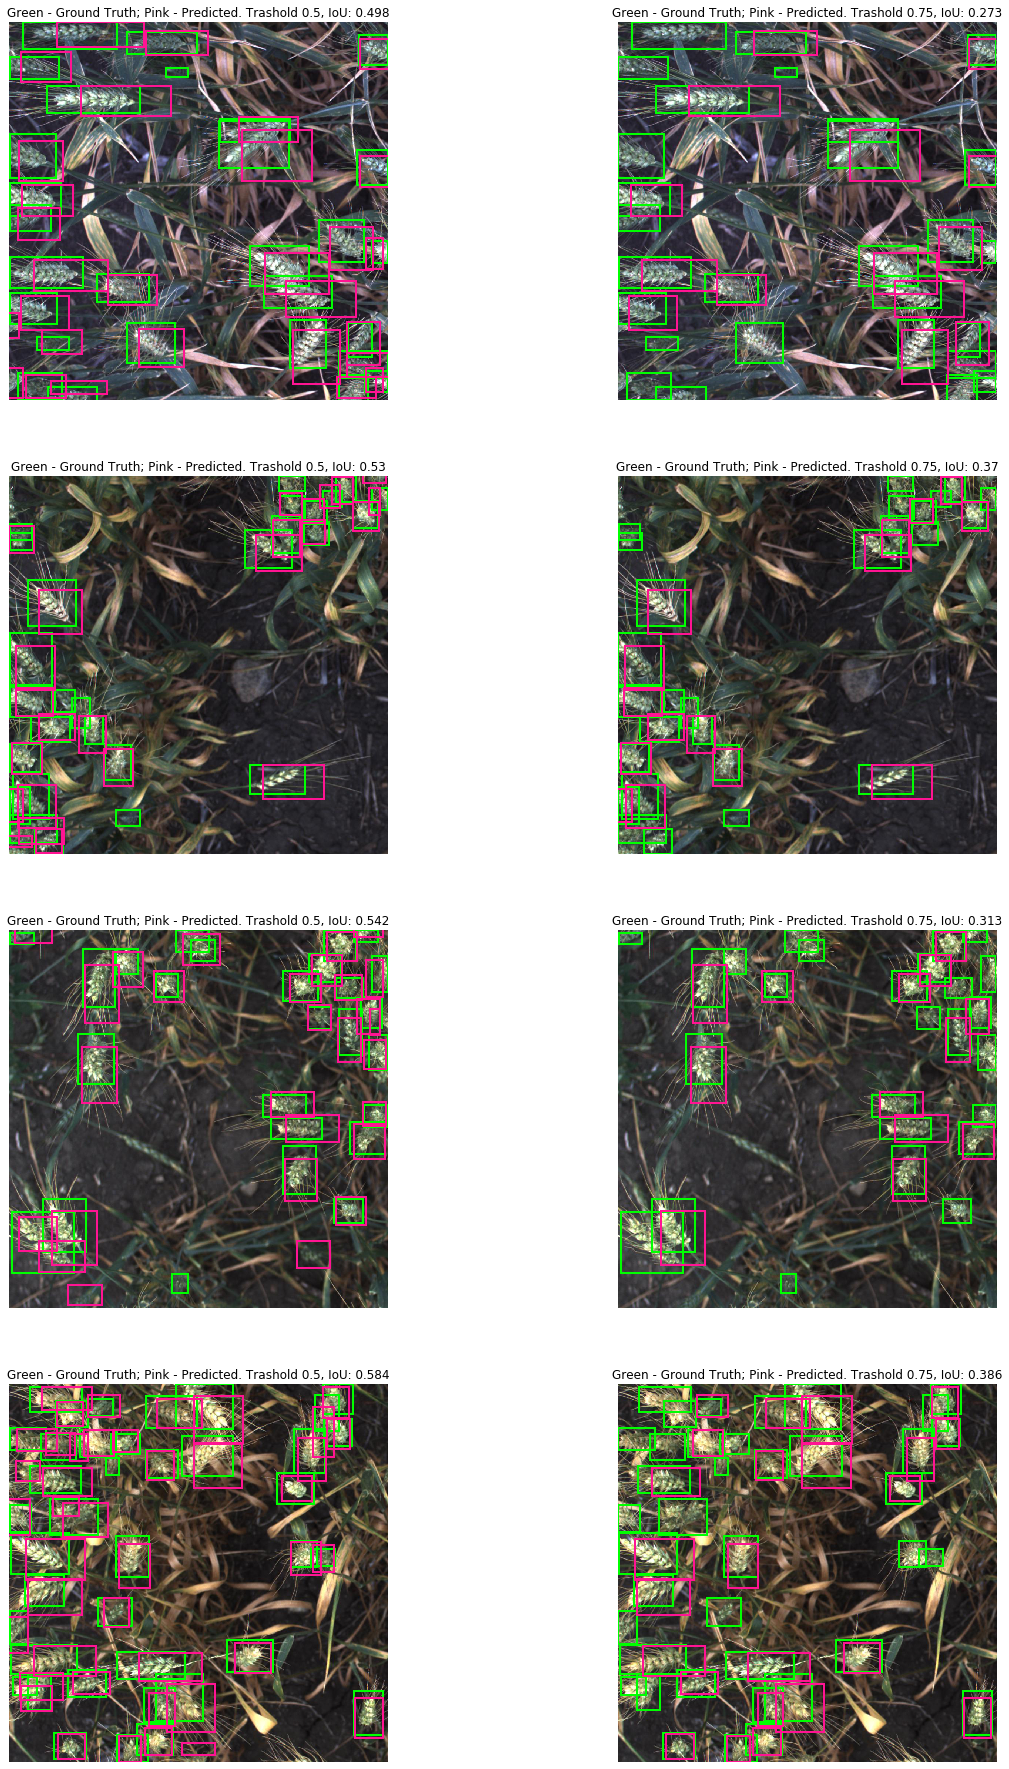

In [9]:
%matplotlib inline
detect_dir = 'output/images'
#detect_dir_50 = 'output/threshold50/images'
lb_dir_50 = 'output/threshold50/labels'
lb_dir_75 = 'output/threshold75/labels'
file_names = os.listdir(detect_dir)
sh=-35
demo_imgs = list(df_val.nsmallest(6, ['iou50'])['image_id'])
demo_imgs = list(dict.fromkeys(demo_imgs))
demo_imgs = [name + '.jpg' for name in demo_imgs]
n_samples = len(demo_imgs)

fig, ax = plt.subplots(n_samples, 2, figsize=(20, 8 * n_samples))
for n, fl_name in enumerate(demo_imgs):
    for col in range(2):
        file_path = os.path.join(detect_dir, fl_name)
        img = plt.imread(file_path)
        ax[n,col].imshow(img)
        ax[n,col].axis('off')
        #ax[n,col].set_title('Green - Ground Truth; Pink - Predicted. IoU: 0.000')
        # read ground truth bounded boxes from CSV
        img_name = fl_name[:-4]
        for i, box in df_val[df_val['image_id']==img_name].iterrows():
            rect = patches.Rectangle((box.box_x,box.box_y),box.box_w,box.box_h,
                                linewidth=2,edgecolor='lime',facecolor='none')
            ax[n,col].add_patch(rect)
        
        if col==0:
            iou_im = df_val[df_val['image_id']==img_name]['iou50'].mean()
            ax[n,col].set_title('Green - Ground Truth; Pink - Predicted. Trashold 0.5, IoU: {}'.format(round(iou_im, 3)))
        else:
            iou_im = df_val[df_val['image_id']==img_name]['iou75'].mean()
            ax[n,col].set_title('Green - Ground Truth; Pink - Predicted. Trashold 0.75, IoU: {}'.format(round(iou_im, 3)))       
        txt_fl_name = fl_name[:-4]+'.txt'
        # read predicted bounded boxes from *.txt files (treshold 0.5/0.75)
        txt_fl_name = fl_name[:-4]+'.txt'
        if col==0:
            file_path = os.path.join(lb_dir_50, txt_fl_name)
        else:
            file_path = os.path.join(lb_dir_75, txt_fl_name)
        box_file = open(file_path, "r")
        for aline in box_file:
            values = np.array(aline.split()).astype(np.float)
            rect = patches.Rectangle((int(values[1]*1024+sh), int(values[2]*1024 + sh)),
                                    values[3]*1024, values[4]*1024,
                                linewidth=2,edgecolor='deeppink',facecolor='none')
            ax[n,col].add_patch(rect)
        box_file.close()